In [1]:
# Import needed libaries
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# read in dataset and remove previouly set multiindex
df = pd.read_pickle("./Data/process_data_df10.pkl")

df = df.droplevel(level=0,axis=1)

# drop na and duplicates from qc_serien number since following assumption is made:
# every qc has one serial number, if it occurs twice the sample has been tested twice, since there are
# less than 1000 duplicates (less than 0.5 % of whole dataset) to keep them
df = df.dropna(subset = ['qc_serien_nummer']).drop_duplicates(subset = ['qc_serien_nummer'])#.set_index('qc_serien_nummer')


df = df[df['qc_salzrckhalt']!=0]

# Updating Reference and Richtwerte naming
- Renaming columns named richtwert into ref for easier filtering

In [2]:
# renaming columns named richtwert into ref for better filtering


df.rename(columns={'pa_cm-pda_gewichts-%_richtwert_ref_low':'pa_cm-pda_gewichts-%_ref_low'}, inplace=True)
df.rename(columns={'pa_cm-pda_gewichts-%_richtwert_ref_high':'pa_cm-pda_gewichts-%_ref_high'}, inplace=True)
df.rename(columns={'pa_chlorkonzentration_richtwert_low_ppm':'pa_chlorkonzentration_ref_low_ppm'}, inplace=True)
df.rename(columns={'pa_chlorkonzentration_richtwert_high_ppm':'pa_chlorkonzentration_ref_high_ppm'}, inplace=True)

In [3]:
df1 = df.copy()

In [4]:
result = pd.concat([df1.filter(regex = '_ref'),df1.filter(regex = '_richtwert_')], axis = 1, sort = False)
result1 = result.loc[:,~result.columns.duplicated()]
result2 = result1.join(df['p_product'])
result1.drop('pa_ref', axis=1, inplace = True)

In [5]:
Richtwerte = list(result1.columns)#.remove('p_product')


In [6]:
df1 = df1.drop(result1, axis = 1) #drop ref temporaly

# Make mean columns

In [7]:
# Multiple Measurment columns
meanList = ['pa_cm-pda','pa_chlorkonzentration','pa_air-knife_vor_amin_bad','airknife_vor_amin_trockner',
            'pa_amin-trockner_feuchtigkeit_danfugt_bs',
            'pa_amin-trockner_feuchtigkeit_danfugt_as',
            'pa_amin-trockner_feuchtigkeit_cofely',
            'ps_dicke','ps_bad_temperatur',
            'ps_auftragswerk_feuchtigkeit',
            'sc_d_links_werte',
            'sc_d_rechts_werte']

# Funktion to drop multiple measurment values
def MeanColumnCreate(meanList, df):
  for i in meanList:
      filterdf = df.filter(regex = i)
      name = i+"_mean"
      df[name] = filterdf.iloc[:].mean(axis = 1)
      df.drop(filterdf, axis = 1, inplace = True)
    
MeanColumnCreate(meanList, df1)

# Rename air-knife vor amin bad mean to airknife ....
df1.rename(columns={'pa_air-knife_vor_amin_bad_mean':'pa_airknife_vor_amin_bad_mean'}, inplace=True)

In [8]:
df2 = df1.copy()

In [9]:
# rejoin refvalues back to dataframe
df2 = df2.join(result1)

# Lists for name pattern search
- List has been created manually

In [10]:
# List of features that have low and high reference values
RefDouble =  ['pa_cm-pda','pa_chlorkonzentration',
            'airknife_vor_amin_trockner',
            'pa_amin-trockner_feuchtigkeit_danfugt_bs',
            'pa_amin-trockner_feuchtigkeit_danfugt_as',
            'pa_amin-trockner_feuchtigkeit_cofely',
            'pa_vertikale_feuchte_oben',
            'pa_temperatur_n-decan-lsg', 
            'pa_temperatur_alkali-lsg']

# List of features that have only one reference value
RefSingle = ['pa_bahngeschwindigkeit', 'ct1',
                 'pa_staubsauger',
                 'pa_airknife_vor_amin_bad',
                 'pa_amin-trockner_temperatur_danfugt',
                 'pa_decan-trockner_geblase']
                 

In [11]:
df3 = df2.copy()

# Function for calculating with low and high ref value

In [12]:
def doubleRef(df, RefListDouble):
    for i in RefListDouble:
        mask = df.filter(regex = i)
        mean = list(mask.filter(regex = i).columns)[0]  # because mean is vor ref values
        low = list(mask.filter(regex = 'ref').columns)[0] #columname of corresponding low ref column
        high = list(mask.filter(regex = 'ref').columns)[1] #columname of corresponding high ref column
        
        # Creating temporaly columns via boolean indexing
        # Only one per row of the temporaly made columns is filled with values (Boolean Array like)
        
        df[i+"_diff_low"] = np.where((df[mean] < df[low]),(df[low] -df[mean]), 0) 
        df[i+"_diff_high"] = np.where((df[mean] > df[high]),(df[high] -df3[mean]), 0)
        df[i+"diff_none"] = np.where((df[mean] <df[high]) & (df[mean]>df[low]),(df[mean]), 0)
        
        # Create difference column and drop all temporaliy made columns
        
        df[i+"_diff"] = df[i+"_diff_low"]+df[i+"_diff_high"]+df[i+"diff_none"]  
        df.drop([i+"_diff_low" ,i+"_diff_high",i+"diff_none"], axis = 1, inplace = True)
        

In [13]:
doubleRef(df3,RefDouble)

In [14]:
df3.filter(regex = 'chlorkonzentration')

,pa_chlorkonzentration_mean,pa_chlorkonzentration_ref_low_ppm,pa_chlorkonzentration_ref_high_ppm,pa_chlorkonzentration_diff
0,1558.000000,1560.0,1700.0,2.000000
1,1558.000000,1560.0,1700.0,2.000000
2,1558.000000,1560.0,1700.0,2.000000
3,1558.000000,1560.0,1700.0,2.000000
4,1558.000000,1560.0,1700.0,2.000000
...,...,...,...,...
118682,913.555556,1560.0,1700.0,646.444444
118683,913.555556,1560.0,1700.0,646.444444
118684,913.555556,1560.0,1700.0,646.444444
118685,913.555556,1560.0,1700.0,646.444444


# Calulate for ct1_values the diff between ref and high

In [15]:
ct1FeatureList = list(df3.filter(regex = 'ct1_').columns)[:-2]
ct1RefList = list(df3.filter(regex = 'ct1_').columns)[8:]

ct1FeatureList

['ct1_anfang_0m_%',
 'ct1_anfang_flux_m3/m2/d',
 'ct1_mitte_1_1400m_rej_%',
 'ct1_mitte_1_1400m_flux',
 'ct1_mitte_2_2900m_rej_%',
 'ct1_mitte_2_2900m_flux',
 'ct1_ende_4300m_rej_%',
 'ct1_ende_flux_m3/m2/d']

In [16]:
ct1RefList

['ct1_test_ref_low', 'ct1_test_ref_high']

In [17]:
df3.filter(regex = 'ct1')

,ct1_anfang_0m_%,ct1_anfang_flux_m3/m2/d,ct1_mitte_1_1400m_rej_%,ct1_mitte_1_1400m_flux,ct1_mitte_2_2900m_rej_%,ct1_mitte_2_2900m_flux,ct1_ende_4300m_rej_%,ct1_ende_flux_m3/m2/d,ct1_test_ref_low,ct1_test_ref_high
0,99.63,1.49,99.54,1.65,99.58,1.52,99.72,1.49,1.12,99.1
1,99.63,1.49,99.54,1.65,99.58,1.52,99.72,1.49,1.12,99.1
2,99.63,1.49,99.54,1.65,99.58,1.52,99.72,1.49,1.12,99.1
3,99.63,1.49,99.54,1.65,99.58,1.52,99.72,1.49,1.12,99.1
4,99.63,1.49,99.54,1.65,99.58,1.52,99.72,1.49,1.12,99.1
...,...,...,...,...,...,...,...,...,...,...
118682,99.51,1.37,99.49,1.43,0.00,0.00,0.00,0.00,1.12,99.1
118683,99.51,1.37,99.49,1.43,0.00,0.00,0.00,0.00,1.12,99.1
118684,99.51,1.37,99.49,1.43,0.00,0.00,0.00,0.00,1.12,99.1
118685,99.51,1.37,99.49,1.43,0.00,0.00,0.00,0.00,1.12,99.1


In [18]:
for i in ct1FeatureList:
    
        low = ct1RefList[0] #columname of corresponding low ref column
        high = ct1RefList[1] #columname of corresponding high ref column
        
        # Creating temporaly columns via boolean indexing
        # Only one per row of the temporaly made columns is filled with values (Boolean Array like)
        
        df3[i+"_diff_low"] = np.where((df3[i] < df3[low]),(df3[low] -df3[i]), 0) 
        df3[i+"_diff_high"] = np.where((df3[i] > df3[high]),(df3[high] -df3[i]), 0)
        df3[i+"diff_none"] = np.where((df3[i] <df3[high]) & (df3[i]>df3[low]),(df3[i]), 0)
        
        # Create difference column and drop all temporaliy made columns
        
        df3[i+"_diff"] = df3[i+"_diff_low"]+df3[i+"_diff_high"]+df3[i+"diff_none"]  
        df3.drop([i+"_diff_low" ,i+"_diff_high",i+"diff_none"], axis = 1, inplace = True)

In [19]:
df4 = df3.copy()

In [20]:
dada = []
for i in RefSingle:
    mask = df.filter(regex = i)
    names = mask.columns
    dada.append(names)

    
flat_list = []
for sublist in dada:
    for item in sublist:
        flat_list.append(item)
print(flat_list)

['ct1_anfang_0m_%', 'ct1_anfang_flux_m3/m2/d', 'ct1_mitte_1_1400m_rej_%', 'ct1_mitte_1_1400m_flux', 'ct1_mitte_2_2900m_rej_%', 'ct1_mitte_2_2900m_flux', 'ct1_ende_4300m_rej_%', 'ct1_ende_flux_m3/m2/d', 'ct1_test_ref_low', 'ct1_test_ref_high', 'pa_airknife_vor_amin_bad_ref_%', 'pa_amin-trockner_temperatur_danfugt_c', 'pa_amin-trockner_temperatur_danfugt_ref_c', 'pa_decan-trockner_geblase_start_%', 'pa_decan-trockner_geblase_ende_%', 'pa_decan-trockner_geblase_ref_%']


# Function to calculate for single Reference value

In [21]:
restSingleVar =['pa_airknife_vor_amin_bad_mean',
                'pa_amin-trockner_temperatur_danfugt_c',  
                'pa_decan-trockner_geblase_start_%', 
                'pa_decan-trockner_geblase_ende_%', 
                ]

restSingleRef = ['pa_airknife_vor_amin_bad_ref_%',
                'pa_amin-trockner_temperatur_danfugt_ref_c',
                'pa_decan-trockner_geblase_ref_%',
                'pa_decan-trockner_geblase_ref_%']



In [22]:
c=(zip(restSingleVar,restSingleRef))
for i,j in zip(restSingleVar,restSingleRef):
    print("{},{}".format(i,j))

pa_airknife_vor_amin_bad_mean,pa_airknife_vor_amin_bad_ref_%
pa_amin-trockner_temperatur_danfugt_c,pa_amin-trockner_temperatur_danfugt_ref_c
pa_decan-trockner_geblase_start_%,pa_decan-trockner_geblase_ref_%
pa_decan-trockner_geblase_ende_%,pa_decan-trockner_geblase_ref_%


In [23]:
for a,b in zip(restSingleVar,restSingleRef):
     
    df4[a+"_diff"] = np.where((df4[a] > df4[b]) | (df4[a]<df4[b]),(df4[a]-df4[b]), 0)
        

# Turn all _diff named columns into abs() values

In [24]:
diff = list(df4.filter(regex = 'diff').columns)
for i in diff:
    df4[i] = df4[i].abs()

In [25]:
df4

,ps,ps_datum,ps_beschichtete_rollenlange_m,ps_c_losung_wt_%,ps_gap_micro_m,ps_raum_temperatur_start_c,ps_auftragsbank_temperatur_start_c,ps_raum-feuchtigkeit_start_%,ps_datum_coating,ps_out_m,...,ct1_mitte_1_1400m_rej_%_diff,ct1_mitte_1_1400m_flux_diff,ct1_mitte_2_2900m_rej_%_diff,ct1_mitte_2_2900m_flux_diff,ct1_ende_4300m_rej_%_diff,ct1_ende_flux_m3/m2/d_diff,pa_airknife_vor_amin_bad_mean_diff,pa_amin-trockner_temperatur_danfugt_c_diff,pa_decan-trockner_geblase_start_%_diff,pa_decan-trockner_geblase_ende_%_diff
0,cb031d4b18ff,2018-05-13,4487.0,31.0,250.0,24.0,19.0,57.0,2018-05-13,4487.0,...,0.44,1.65,0.48,1.52,0.62,1.49,0.0,0.0,0.0,80.0
1,cb031d4b18ff,2018-05-13,4487.0,31.0,250.0,24.0,19.0,57.0,2018-05-13,4487.0,...,0.44,1.65,0.48,1.52,0.62,1.49,0.0,0.0,0.0,80.0
2,cb031d4b18ff,2018-05-13,4487.0,31.0,250.0,24.0,19.0,57.0,2018-05-13,4487.0,...,0.44,1.65,0.48,1.52,0.62,1.49,0.0,0.0,0.0,80.0
3,cb031d4b18ff,2018-05-13,4487.0,31.0,250.0,24.0,19.0,57.0,2018-05-13,4487.0,...,0.44,1.65,0.48,1.52,0.62,1.49,0.0,0.0,0.0,80.0
4,cb031d4b18ff,2018-05-13,4487.0,31.0,250.0,24.0,19.0,57.0,2018-05-13,4487.0,...,0.44,1.65,0.48,1.52,0.62,1.49,0.0,0.0,0.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118682,3fa606fdd9e8,2018-05-14,2202.0,31.0,250.0,24.0,19.0,46.0,2018-05-13,2202.0,...,0.39,1.43,1.12,1.12,1.12,1.12,40.0,0.0,0.0,80.0
118683,3fa606fdd9e8,2018-05-14,2202.0,31.0,250.0,24.0,19.0,46.0,2018-05-13,2202.0,...,0.39,1.43,1.12,1.12,1.12,1.12,40.0,0.0,0.0,80.0
118684,3fa606fdd9e8,2018-05-14,2202.0,31.0,250.0,24.0,19.0,46.0,2018-05-13,2202.0,...,0.39,1.43,1.12,1.12,1.12,1.12,40.0,0.0,0.0,80.0
118685,3fa606fdd9e8,2018-05-14,2202.0,31.0,250.0,24.0,19.0,46.0,2018-05-13,2202.0,...,0.39,1.43,1.12,1.12,1.12,1.12,40.0,0.0,0.0,80.0


# Test

In [32]:
dftest = df4.copy()
dftest['chlor_durch_mpda']= dftest['pa_chlorkonzentration_mean']/dftest['pa_cm-pda_mean']

In [43]:
dftest['pa_datum'] = pd.to_datetime(dftest['pa_datum'], format='%Y-%m-%d %H:%M:%S')
dftest['pa_datum'] = dftest['pa_datum'].dt.date

# create a 'month_year' column for grouping
dftest['month_year'] = dftest['pa_datum'].map(lambda x: x.strftime('%Y-%m'))

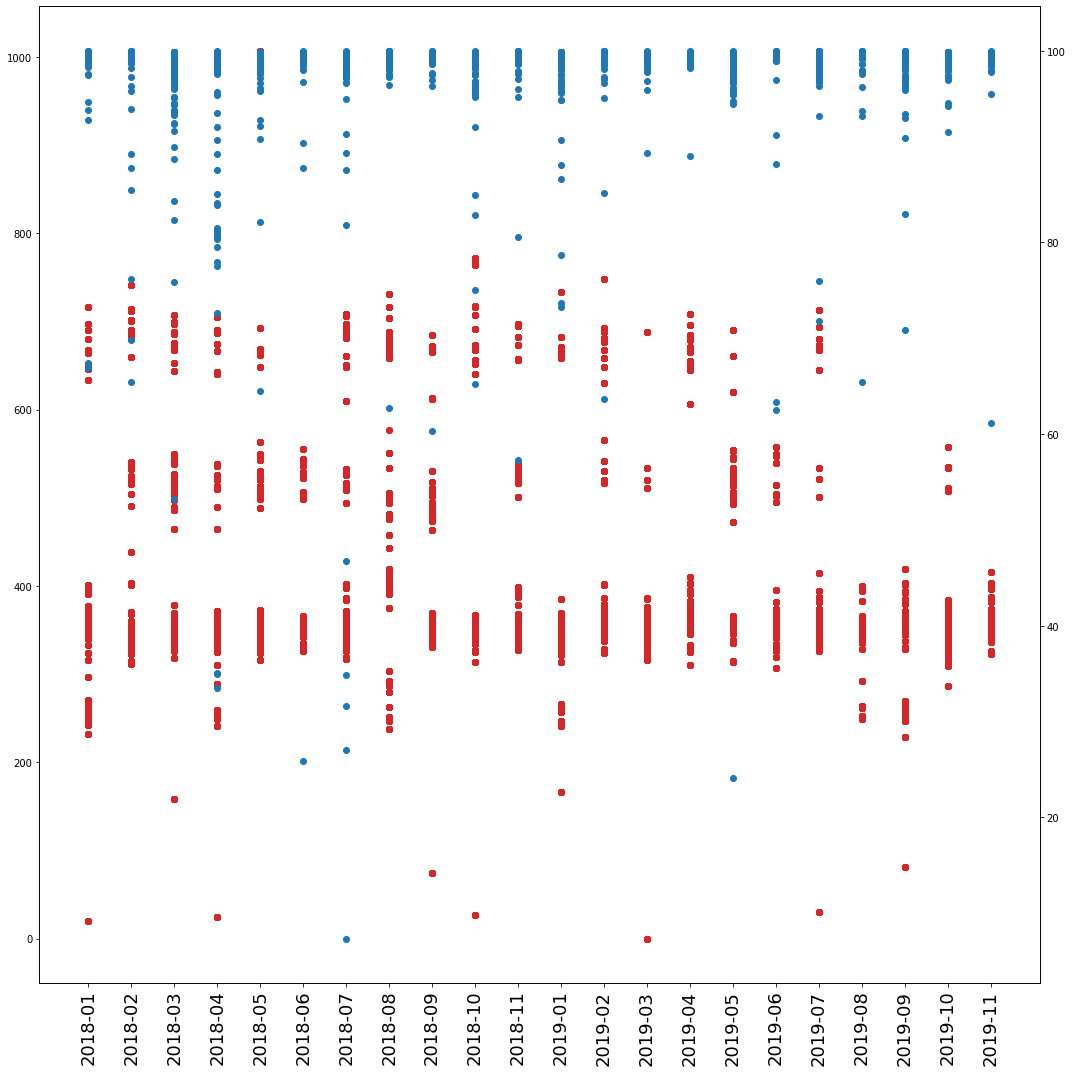

In [66]:
t10 = sorted(list(dftest['month_year'].unique()))
dftest['chlor_durch_mpda'].describe()

fig, ax1 = plt.subplots(figsize=(15,15))
#plt.figure
color = 'tab:red'

ax1.scatter(dftest['month_year'], dftest['chlor_durch_mpda'], color=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.scatter(dftest['month_year'], dftest['qc_salzrckhalt'], color=color)

ax1.set_xticklabels(t10, rotation='vertical', fontsize=18)
#plt.xticks(t10, size='small',rotation=90)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

#plt.scatter(x = dftest['month_year'], y = dftest['chlor_durch_mpda'])

#plt.show()

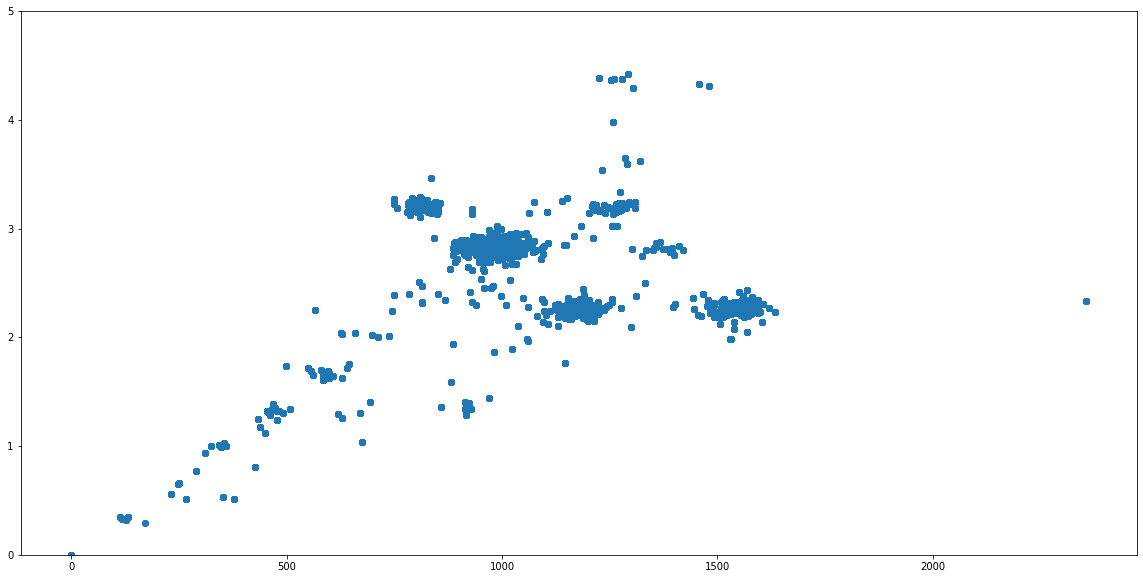

In [69]:
fig = plt.figure(figsize = [20,10])
plt.scatter(x = dftest['pa_chlorkonzentration_mean'], y = dftest['pa_cm-pda_mean'])
plt.ylim(0,5)
plt.show()
# shows that there is clear linear relationsship between cm-pda and chlorkonzentration ()
#### TO DO Heatmap dazu mit relativer abweichung dazu.
#### Normierung aussage ref wert unterscheiden. 

(0, 1600)

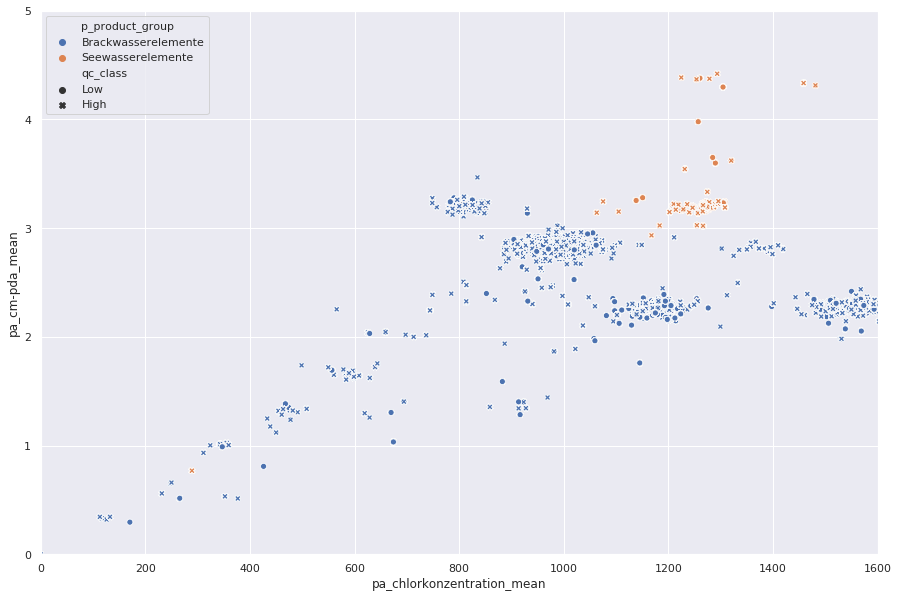

In [177]:
import seaborn as sns
fig = plt.figure(figsize = [15,10])
sns.set()
ax = sns.scatterplot(x = dftest['pa_chlorkonzentration_mean'], y = dftest['pa_cm-pda_mean'],
                     hue= dftest['p_product_group'], style= dftest['qc_class'],
                     markers = True)
ax.set_ylim(0,5)
ax.set_xlim(0,1600)


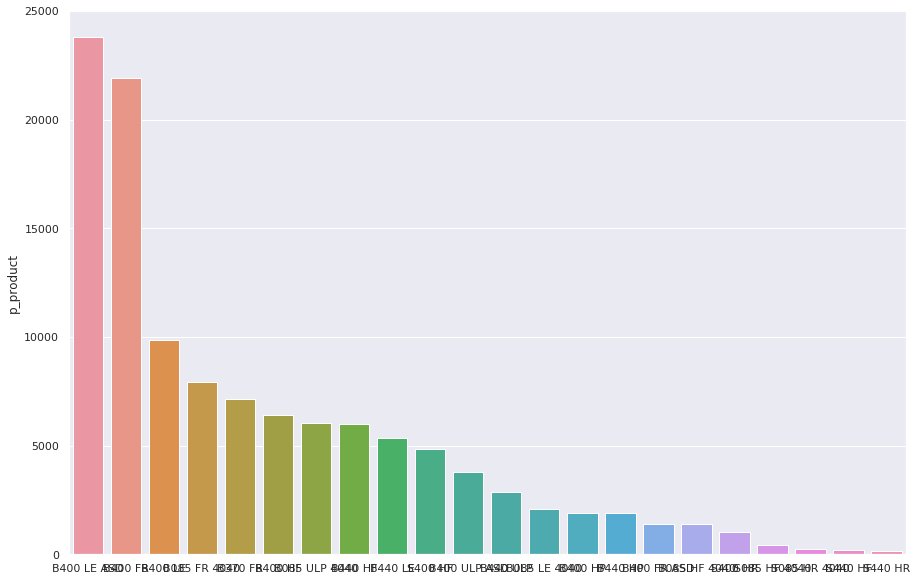

In [169]:
fig = plt.figure(figsize = [15,10])
sns.barplot(x = dftest['p_product'].unique(), y = dftest['p_product'].value_counts())
                     ,#style= dftest['qc_class'])
                     #markers = True)

In [161]:
unique = dftest['p_product'].unique()
nunique = dftest['p_product'].value_counts()
print(unique)
print(nunique)

['B400 LE ASD' 'B400 FR' 'B400 LE' 'B085 FR 4040' 'B370 FR' 'B400 HF'
 'B085 ULP 4040' 'B440 HF' 'B440 LE' 'S400 HF' 'B400 ULP ASD' 'B440 ULP'
 'B085 LE 4040' 'B400 HP' 'B440 HP' 'B400 FR ASD' 'B085 HF 4040' 'S400 HR'
 'S085 HF 4040' 'S085 HR 4040' 'S440 HF' 'S440 HR']
B440 HF          23819
B400 HF          21935
B400 HP           9876
B400 ULP ASD      7916
B400 FR           7154
B440 LE           6407
B085 LE 4040      6041
B370 FR           5977
B400 LE ASD       5330
B085 HF 4040      4849
B440 ULP          3788
S400 HF           2881
B400 LE           2091
B440 HP           1918
B085 ULP 4040     1891
B085 FR 4040      1410
S400 HR           1406
B400 FR ASD       1035
S440 HF            450
S085 HR 4040       237
S085 HF 4040       202
S440 HR            148
Name: p_product, dtype: int64


In [129]:
# classification

dftest['qc_class'] = np.where(dftest['qc_salzrckhalt'] > 99.5,'High', 'Low') 

In [131]:
dftest['qc_class']

0          Low
1         High
2         High
3         High
4         High
          ... 
118682     Low
118683     Low
118684     Low
118685     Low
118686     Low
Name: qc_class, Length: 116761, dtype: object

In [107]:
# 1 to 0
# ln (p/1-p)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

standard = MinMaxScaler()
y_test = np.array(dftest['qc_salzrckhalt']).reshape(-1,1)
y_test1 = standard.fit(y_test)
y_test1 = standard.transform(y_test)
y_test1

array([[0.99405242],
       [0.99486475],
       [0.99478827],
       ...,
       [0.99353996],
       [0.99437276],
       [0.99400112]])

In [108]:
# ln (p/1-p)

yln = np.log(y_test1/(1-y_test1))
yln

/home/elron/anaconda3/envs/da/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


array([[5.11880597],
       [5.26647769],
       [5.25161842],
       ...,
       [5.03563829],
       [5.17449317],
       [5.1101662 ]])

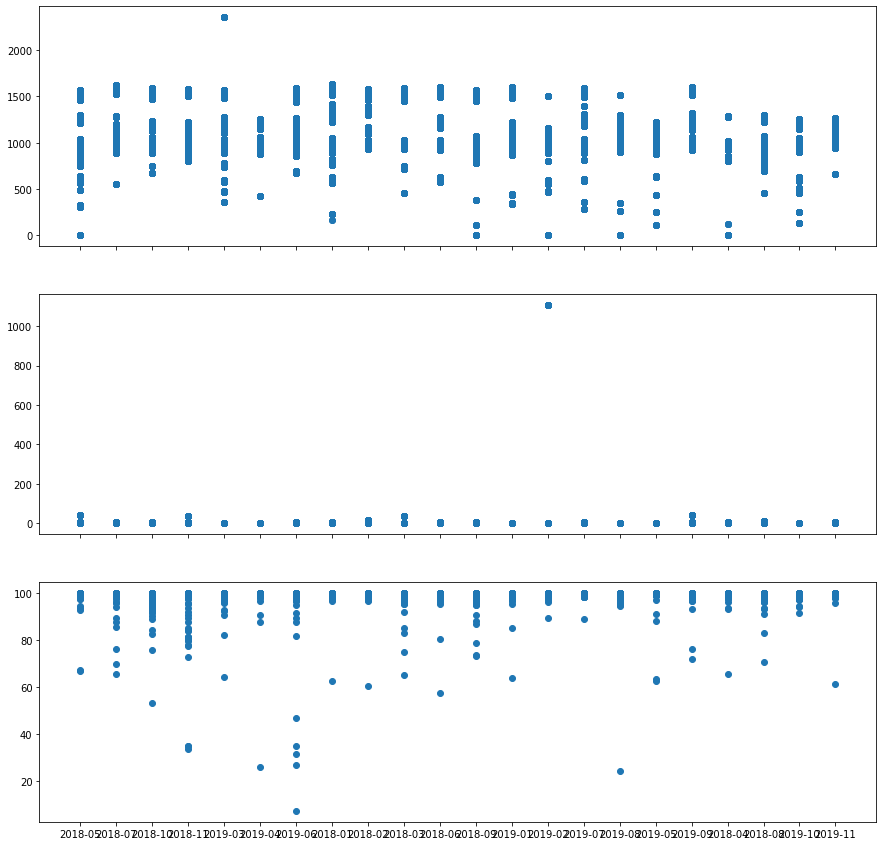

In [124]:
t10 = sorted(list(dftest['month_year'].unique()))
x = dftest['month_year']

fig, axs = plt.subplots(3, sharex=True, sharey=False,figsize=(15,15))
#fig.suptitle('Sharing both axes')

axs[0].scatter(x, dftest['pa_chlorkonzentration_mean'])
axs[1].scatter(x, dftest['pa_cm-pda_mean'])
axs[2].scatter(x, dftest['qc_salzrckhalt'])


plt.show()


In [78]:
dftest[dftest['pa_chlorkonzentration_mean']> 1400]['qc_salzrckhalt']

0         99.455138
1         99.530406
2         99.523320
3         99.567549
4         99.577392
            ...    
117729    99.701730
117730    99.641246
117731    99.684630
117732    99.684028
117733    99.476968
Name: qc_salzrckhalt, Length: 14794, dtype: float64

In [76]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')



# Make data.
X = dftest['pa_chlorkonzentration_mean']
Y = dftest['pa_cm-pda_mean']
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = dftest['qc_salzrckhalt']

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

ValueError: Unknown projection '3d'

<Figure size 432x288 with 0 Axes>

In [75]:
dftest['qc_salzrckhalt']

0         99.455138
1         99.530406
2         99.523320
3         99.567549
4         99.577392
            ...    
118682    99.404884
118683    99.453192
118684    99.407655
118685    99.484820
118686    99.450385
Name: qc_salzrckhalt, Length: 116761, dtype: float64

In [26]:
df5 = df4.filter(regex = 'pa')
df6 = df5.filter(regex = 'diff').join(df4['qc_salzrckhalt']).select_dtypes(include = ['float64'])
dfbool = df5.select_dtypes(include = 'bool')
df6 = df6.join(dfbool)
df6 = df6.join(df['pa_rollen_seit_letztem_bad-wechsel_chlor'])
df6 = df6.join(df['pa_rollen_seit_letztem_bad-wechsel_mpda'])
#df6.to_csv('test.csv')
df6.sample(30)

,pa_cm-pda_diff,pa_chlorkonzentration_diff,pa_amin-trockner_feuchtigkeit_danfugt_bs_diff,pa_amin-trockner_feuchtigkeit_danfugt_as_diff,pa_amin-trockner_feuchtigkeit_cofely_diff,pa_vertikale_feuchte_oben_diff,pa_temperatur_n-decan-lsg_diff,pa_temperatur_alkali-lsg_diff,pa_airknife_vor_amin_bad_mean_diff,pa_amin-trockner_temperatur_danfugt_c_diff,...,qc_salzrckhalt,pa_bad-wechsel_m-pda,pa_bad-wechsel_hw1,pa_bad-wechsel_hw2,pa_bad-wechsel_chlor,pa_bad-wechsel_hw3,pa_bad-wechsel_mpda_nach,pa_bad-wechsel_chlor_nach,pa_rollen_seit_letztem_bad-wechsel_chlor,pa_rollen_seit_letztem_bad-wechsel_mpda
94688,0.071111,950.333333,3.6,6.8,2.0750,38.0,2.00,1.50,10.0000,0.0,...,99.725319,False,False,True,False,False,False,False,3,3
95349,0.077778,983.777778,2.0,3.8,2.1250,38.0,1.00,22.00,10.0000,0.0,...,99.714750,True,True,True,True,True,False,False,1,1
31316,0.038889,1047.333333,0.6,3.2,1.9875,47.0,0.79,0.36,8.1250,0.0,...,99.694883,False,False,True,False,False,True,True,0,0
109384,0.141111,1017.777778,5.8,7.4,2.2625,34.0,26.17,21.46,10.0000,0.0,...,99.719819,False,False,True,False,False,False,False,1,1
116666,0.884444,163.111111,28.6,28.6,30.5625,34.0,24.00,21.00,43.7500,0.0,...,99.768793,False,False,True,False,False,False,False,2,2
33955,0.095556,968.333333,6.4,8.0,2.0625,38.0,27.30,22.20,10.0000,0.0,...,99.666362,False,False,True,False,False,False,False,2,2
67483,0.091111,1033.444444,0.4,1.4,2.8000,46.0,0.70,0.40,10.0000,0.0,...,99.743197,False,False,True,False,False,False,False,2,2
41412,0.021111,110.000000,2.0,54.2,3.0625,42.0,25.36,1.09,20.0000,0.0,...,99.774008,False,False,True,False,False,False,False,2,2
38861,0.004444,259.666667,3.2,0.8,80.6250,4.0,4.00,0.50,10.0000,0.0,...,99.537785,False,False,True,False,False,False,False,1,1
15046,2.906667,997.555556,1.0,0.4,96.6000,45.0,1.30,1.04,10.0000,0.0,...,99.680945,False,False,True,False,False,False,False,1,1


In [28]:
dfmin = df6[df6['qc_salzrckhalt']< 99.5]
for i in list(dfmin.select_dtypes(include = 'bool')):
    dfmin[i] = dfmin[i].map({True : 1, False : 0})




/home/elron/anaconda3/envs/da/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
dfmax = df6[df6['qc_salzrckhalt'] > 99.5]
for i in list(dfmax.select_dtypes(include = 'bool')):
    dfmax[i] = dfmax[i].map({True : 1, False : 0})


/home/elron/anaconda3/envs/da/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
dfmax

,pa_cm-pda_diff,pa_chlorkonzentration_diff,pa_amin-trockner_feuchtigkeit_danfugt_bs_diff,pa_amin-trockner_feuchtigkeit_danfugt_as_diff,pa_amin-trockner_feuchtigkeit_cofely_diff,pa_vertikale_feuchte_oben_diff,pa_temperatur_n-decan-lsg_diff,pa_temperatur_alkali-lsg_diff,pa_airknife_vor_amin_bad_mean_diff,pa_amin-trockner_temperatur_danfugt_c_diff,...,qc_salzrckhalt,pa_bad-wechsel_m-pda,pa_bad-wechsel_hw1,pa_bad-wechsel_hw2,pa_bad-wechsel_chlor,pa_bad-wechsel_hw3,pa_bad-wechsel_mpda_nach,pa_bad-wechsel_chlor_nach,pa_rollen_seit_letztem_bad-wechsel_chlor,pa_rollen_seit_letztem_bad-wechsel_mpda
1,2.332222,2.000000,0.0,1.0,79.8500,6.0,1.75,0.73,0.0,0.0,...,99.530406,0,0,1,0,0,0,0,2,2
2,2.332222,2.000000,0.0,1.0,79.8500,6.0,1.75,0.73,0.0,0.0,...,99.523320,0,0,1,0,0,0,0,2,2
3,2.332222,2.000000,0.0,1.0,79.8500,6.0,1.75,0.73,0.0,0.0,...,99.567549,0,0,1,0,0,0,0,2,2
4,2.332222,2.000000,0.0,1.0,79.8500,6.0,1.75,0.73,0.0,0.0,...,99.577392,0,0,1,0,0,0,0,2,2
5,2.332222,2.000000,0.0,1.0,79.8500,6.0,1.75,0.73,0.0,0.0,...,99.562498,0,0,1,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118608,0.021111,1019.888889,0.2,59.2,3.5250,46.0,0.69,0.89,10.0,0.0,...,99.839814,0,0,1,0,0,0,0,2,2
118609,0.021111,1019.888889,0.2,59.2,3.5250,46.0,0.69,0.89,10.0,0.0,...,99.836000,0,0,1,0,0,0,0,2,2
118610,0.021111,1019.888889,0.2,59.2,3.5250,46.0,0.69,0.89,10.0,0.0,...,99.830880,0,0,1,0,0,0,0,2,2
118611,0.021111,1019.888889,0.2,59.2,3.5250,46.0,0.69,0.89,10.0,0.0,...,99.566659,0,0,1,0,0,0,0,2,2


In [29]:
dfmin

,pa_cm-pda_diff,pa_chlorkonzentration_diff,pa_amin-trockner_feuchtigkeit_danfugt_bs_diff,pa_amin-trockner_feuchtigkeit_danfugt_as_diff,pa_amin-trockner_feuchtigkeit_cofely_diff,pa_vertikale_feuchte_oben_diff,pa_temperatur_n-decan-lsg_diff,pa_temperatur_alkali-lsg_diff,pa_airknife_vor_amin_bad_mean_diff,pa_amin-trockner_temperatur_danfugt_c_diff,...,qc_salzrckhalt,pa_bad-wechsel_m-pda,pa_bad-wechsel_hw1,pa_bad-wechsel_hw2,pa_bad-wechsel_chlor,pa_bad-wechsel_hw3,pa_bad-wechsel_mpda_nach,pa_bad-wechsel_chlor_nach,pa_rollen_seit_letztem_bad-wechsel_chlor,pa_rollen_seit_letztem_bad-wechsel_mpda
0,2.332222,2.000000,0.0,1.0,79.8500,6.0,1.75,0.73,0.0,0.0,...,99.455138,0,0,1,0,0,0,0,2,2
69,2.332222,2.000000,0.0,1.0,79.8500,6.0,1.75,0.73,0.0,0.0,...,99.389165,0,0,1,0,0,0,0,2,2
86,0.154444,973.111111,1.0,0.8,3.0875,35.0,1.34,0.63,20.0,0.0,...,99.431954,0,0,1,0,0,1,1,0,0
95,0.154444,973.111111,1.0,0.8,3.0875,35.0,1.34,0.63,20.0,0.0,...,99.499038,0,0,1,0,0,1,1,0,0
174,0.154444,973.111111,1.0,0.8,3.0875,35.0,1.34,0.63,20.0,0.0,...,99.248721,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118682,0.897778,646.444444,21.2,22.6,39.2125,3.0,26.70,0.10,40.0,0.0,...,99.404884,1,1,1,1,1,0,0,1,1
118683,0.897778,646.444444,21.2,22.6,39.2125,3.0,26.70,0.10,40.0,0.0,...,99.453192,1,1,1,1,1,0,0,1,1
118684,0.897778,646.444444,21.2,22.6,39.2125,3.0,26.70,0.10,40.0,0.0,...,99.407655,1,1,1,1,1,0,0,1,1
118685,0.897778,646.444444,21.2,22.6,39.2125,3.0,26.70,0.10,40.0,0.0,...,99.484820,1,1,1,1,1,0,0,1,1


In [73]:
X = dfmin
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=9, random_state=0).fit(X)
print(kmeans.labels_)

[3 3 4 ... 8 8 8]


In [74]:
df['pa_rollen_seit_letztem_bad-wechsel_chlor']

0         2
1         2
2         2
3         2
4         2
         ..
118682    1
118683    1
118684    1
118685    1
118686    1
Name: pa_rollen_seit_letztem_bad-wechsel_chlor, Length: 116761, dtype: int64

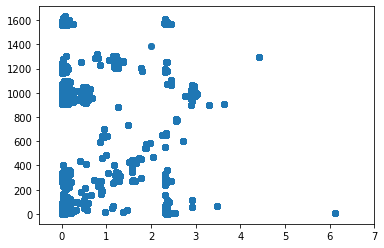

In [65]:
df7 = df6.copy()
diff = list(df7.filter(regex = 'diff').columns)

plt.scatter(x = df6['pa_cm-pda_diff'], y = df6['pa_chlorkonzentration_diff'])
plt.xlim(-0.5,7)
plt.show()

In [48]:
df7.join(df6.select_dtypes(include = 'bool'))

,pa_cm-pda_diff,pa_chlorkonzentration_diff,pa_amin-trockner_feuchtigkeit_danfugt_bs_diff,pa_amin-trockner_feuchtigkeit_danfugt_as_diff,pa_amin-trockner_feuchtigkeit_cofely_diff,pa_vertikale_feuchte_oben_diff,pa_temperatur_n-decan-lsg_diff,pa_temperatur_alkali-lsg_diff,pa_airknife_vor_amin_bad_mean_diff,pa_amin-trockner_temperatur_danfugt_c_diff,pa_decan-trockner_geblase_start_%_diff,pa_decan-trockner_geblase_ende_%_diff,qc_salzrckhalt
0,2.332222,2.000000,0.0,1.0,79.8500,6.0,1.75,0.73,0.0,0.0,0.0,80.0,99.455138
1,2.332222,2.000000,0.0,1.0,79.8500,6.0,1.75,0.73,0.0,0.0,0.0,80.0,99.530406
2,2.332222,2.000000,0.0,1.0,79.8500,6.0,1.75,0.73,0.0,0.0,0.0,80.0,99.523320
3,2.332222,2.000000,0.0,1.0,79.8500,6.0,1.75,0.73,0.0,0.0,0.0,80.0,99.567549
4,2.332222,2.000000,0.0,1.0,79.8500,6.0,1.75,0.73,0.0,0.0,0.0,80.0,99.577392
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118682,0.897778,646.444444,21.2,22.6,39.2125,3.0,26.70,0.10,40.0,0.0,0.0,80.0,99.404884
118683,0.897778,646.444444,21.2,22.6,39.2125,3.0,26.70,0.10,40.0,0.0,0.0,80.0,99.453192
118684,0.897778,646.444444,21.2,22.6,39.2125,3.0,26.70,0.10,40.0,0.0,0.0,80.0,99.407655
118685,0.897778,646.444444,21.2,22.6,39.2125,3.0,26.70,0.10,40.0,0.0,0.0,80.0,99.484820


In [95]:
df4['p_product']

0         B400 LE ASD
1         B400 LE ASD
2         B400 LE ASD
3         B400 LE ASD
4         B400 LE ASD
             ...     
118682    B400 LE ASD
118683    B400 LE ASD
118684    B400 LE ASD
118685    B400 LE ASD
118686    B400 LE ASD
Name: p_product, Length: 116761, dtype: object

In [89]:
# and / or, combi as matrix , clustering into small groups
# verhältnis mpda zu chlor

df4['chlor_durch_mpda']= df4['pa_chlorkonzentration_mean']/df4['pa_cm-pda_mean']

In [96]:
df4.groupby('p_product')['chlor_durch_mpda'].describe()

,count,mean,std,min,25%,50%,75%,max
p_product,,,,,,,,
B085 FR 4040,1410.0,362.338970,9.886665,343.311102,355.607659,369.451074,370.986920,370.986920
B085 HF 4040,4849.0,355.289349,15.784749,326.884884,343.311102,354.241436,362.212530,384.630659
B085 LE 4040,6041.0,613.964996,135.946646,345.324020,656.286837,666.977887,696.867470,731.557989
B085 ULP 4040,1891.0,522.446402,25.038541,490.790743,500.905624,513.475883,530.738523,565.131919
B370 FR,5883.0,300.941429,119.620447,19.735697,247.640685,256.544321,270.386114,697.314453
B400 FR,7154.0,349.215109,72.964886,26.787657,338.858268,349.399038,356.143079,769.949636
B400 FR ASD,1035.0,283.264429,38.538729,247.101701,251.955903,265.164645,338.671875,348.143760
B400 HF,21667.0,358.973240,55.789197,158.037825,344.440016,351.732673,358.957006,685.116974
B400 HP,9876.0,347.181618,37.826631,0.002624,340.773216,349.885145,358.519389,415.320122


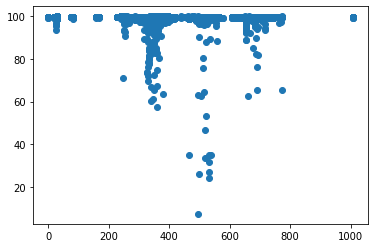

In [87]:
plt.scatter(x = X, y = df4['qc_salzrckhalt'])
#plt.xlim(0,10)
plt.show()